In [178]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torchvision.models import densenet121,inception_v3,densenet201,resnet152,resnet18
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import glob
%matplotlib inline
from tqdm import tqdm
tqdm.pandas()

In [179]:
# 訓練データの確認
df = pd.read_csv("../data/train.csv")
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [180]:
# one-hot表現をラベル表現に変換する
columns = ["healthy", "multiple_diseases", "rust", "scab"]
target = []
for i in tqdm(range(len(df))):
    target.append(columns[np.argmax(df.iloc[i].values[1:])])

df["Target"] = target
df["Target"] = LabelEncoder().fit_transform(df["Target"])
df.head()

100%|██████████| 1821/1821 [00:00<00:00, 12135.65it/s]


,image_id,healthy,multiple_diseases,rust,scab,Target
0,Train_0,0,0,0,1,3
1,Train_1,0,1,0,0,1
2,Train_2,1,0,0,0,0
3,Train_3,0,0,1,0,2
4,Train_4,1,0,0,0,0


d:\Projects\01_kaggle\Plant_Pathology_2020_FGVC7\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


各ラベルの出現回数
2    622
3    592
0    516
1     91
Name: Target, dtype: int64


<AxesSubplot:xlabel='Target', ylabel='count'>

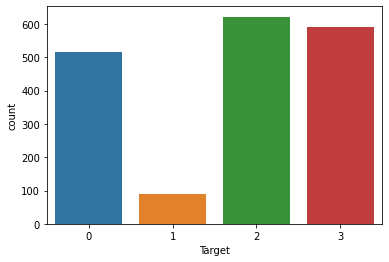

In [181]:
print("各ラベルの出現回数")
print(df["Target"].value_counts())
sns.countplot(df["Target"])

In [182]:
class PlantDataset(Dataset):
    def __init__(self, csv, transformer):
        self.data = csv
        self.transformer = transformer
        self.labels = torch.eye(4)[self.data["Target"]]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = Image.open("../data/images/" + self.data.loc[idx]["image_id"] + ".jpg")
        image = self.transformer(image)
        labels = torch.tensor(self.data.loc[idx]["Target"])
        return {"images": image, "labels": labels}

In [183]:
class ImageTransform:
    def __init__(self, resize, mean, std):
        self.data_transform = {
            "train": transforms.Compose(
                [
                    # 訓練時のみデータオーグメンテーション
                    transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                ]
            ),
            "val": transforms.Compose(
                [
                    transforms.Resize(resize),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                ]
            ),
        }

    def __call__(self, image, phase="train"):
        return self.data_transform[phase](image)

In [184]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# transform = ImageTransform(size, mean, std)
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize([0.496,0.456,0.406],[0.229,0.224,0.225])])
train_dataset = PlantDataset(df, transform)

In [185]:
# trainとtestを分割
indices = range(len(train_dataset))
split = int(0.1 * len(train_dataset))
train_indices = indices[split:]
test_indices = indices[:split]

In [186]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(train_dataset, sampler = train_sampler, batch_size=32)
valid_loader = DataLoader(train_dataset,sampler = valid_sampler, batch_size=32)

In [187]:
model = resnet18(pretrained=True)

# 基底モデルは凍結
for param in model.parameters():
    param.trainable = False

# Linearレイヤの出力を4に変更
model.fc = nn.Linear(512,4)
fc_parameters = model.fc.parameters()

# 付け替えたLinearレイヤは学習可能にする
for param in fc_parameters:
    param.trainable = True

if torch.cuda.is_available():
    model = model.cuda()

In [188]:
# 損失関数
criteria = nn.CrossEntropyLoss()
# オプティマイザ
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [189]:
def fit(epochs, model, criteria, optimizer):
    for epoch in range(epochs + 1):
        training_loss = 0.0
        validation_loss = 0.0
        correct = 0.0
        total = 0.0

        print(f"{epoch + 1}/{epochs} Epochs")

        # training
        model.train()
        for batch_idx, d in enumerate(train_loader):
            data = d["images"]
            target = d["labels"]

            if torch.cuda.is_available():
                data = data.cuda()
                target = darget.cuda()
            
            optimizer.zero_grad()
            output = model(data)
            loss = criteria(output, target.long())
            loss.backward()
            optimizer.step()

            pred = output.data.max(1, keepdim=True)[1]

            training_loss = training_loss + (1 + (batch_idx + 1) * (loss.data - training_loss))
            
            if batch_idx % 20 == 0:
                print(f"batch_Idx = [{batch_idx}], training_loss = [{training_loss}]")

            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())

            total += data.size(0)
            print(f"batch_Idx = [{batch_idx}], training_accuracy = [{correct * 100 / total}]")

        # validation
        for batch_idx, d in enumerate(valid_loader):
            data = d["images"]
            target = d["labels"]

            if torch.cuda.is_available():
                data = data.cuda()
                target = darget.cuda()
            
            output = model(data)
            loss = criteria(output, target.long())
            
            validation_loss = validation_loss + (1 / (batch_idx + 1)) * (loss.data - validation_loss)
            pred = output.data.max(1, keepdim=True)[1]
            if batch_idx % 20 == 0:
                print(f"batch_Idx = [{batch_idx}], validation_loss = [{validation_loss}]")

            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())

            total += data.size(0)
            print(f"batch_Idx = [{batch_idx}], validation_accuracy = [{correct * 100 / total}]")

In [190]:
fit(20, model, criteria, optimizer)

1/20 Epochs
batch_Idx = [0], training_loss = [2.529215097427368]
batch_Idx = [0], training_accuracy = [31.25]
batch_Idx = [1], training_accuracy = [45.3125]
batch_Idx = [2], training_accuracy = [53.125]
batch_Idx = [3], training_accuracy = [60.9375]
batch_Idx = [4], training_accuracy = [62.5]
batch_Idx = [5], training_accuracy = [64.0625]
batch_Idx = [6], training_accuracy = [65.625]
batch_Idx = [7], training_accuracy = [67.578125]
batch_Idx = [8], training_accuracy = [68.05555555555556]
batch_Idx = [9], training_accuracy = [68.75]
batch_Idx = [10], training_accuracy = [71.02272727272727]
batch_Idx = [11], training_accuracy = [72.91666666666667]
batch_Idx = [12], training_accuracy = [74.03846153846153]
batch_Idx = [13], training_accuracy = [75.44642857142857]
batch_Idx = [14], training_accuracy = [75.41666666666667]
batch_Idx = [15], training_accuracy = [75.5859375]
batch_Idx = [16], training_accuracy = [75.91911764705883]
batch_Idx = [17], training_accuracy = [76.21527777777777]
batch